In [14]:
!pip install onnxruntime

In [15]:
import sys, os, distutils.core

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
POSE_MODEL_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models'
APPAREL_MODEL_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models'
BODY_PARSING_MODEL = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models'
INPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/input'
OUTPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output'
# if not os.path.exists(MODEL_DIR):
#     os.makedirs(MODEL_DIR)

if not os.path.exists(INPUT_DIR):
    os.makedirs(INPUT_DIR)

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if not os.path.exists(OUTPUT_DIR+"/bodysegmask"):
    os.makedirs(OUTPUT_DIR+"/bodysegmask")


In [18]:
import onnxruntime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


#classes that the model can detect (some classes are not specifically identified, see below):

* 0: "background",
* 1: "unknown",
* 2: "hair",
* 3: "unknown",
* 4: "glasses",
*5: "top-clothes",
*6: "unknown",
*7: "unknown",
*8: "unknown",
*9: "bottom-clothes",
*10: "torso-skin",
*11: "unknown",
*12: "unknown",
*13: "face",
*14: "left-arm",
*15: "right-arm",
*16: "left-leg",
*17: "right-leg",
*18: "left-foot",
*19: "right-foot",


In [19]:
def print_individual_class_masks():

  num_classes = 21 # Define the number of classes. The model predicts 21 classes including background.

  # ---- Display each class separately ----
  for i in range(num_classes):
      detected = result == i
      if np.sum(detected) == 0:
          continue
      class_mask = np.zeros((512, 512, 3), dtype=np.uint8)
      class_mask[detected] = colors[i]

      plt.figure(figsize=(4, 4))
      plt.imshow(class_mask)
      plt.title(f"Class {i} Mask")
      plt.axis('off')
      plt.show()

      # Image.fromarray(class_mask).save(f"segmentation_mask_class_{i}.png")
      Image.fromarray(class_mask).save(os.path.join(OUTPUT_DIR, "bodysegmask", f"segmentation_mask_class_{i}.png"))

      # print(f"Segmentation mask for class {i} saved as segmentation_mask_class_{i}.png")
      print(f"Segmentation mask for class {i} saved as {os.path.join(OUTPUT_DIR, 'bodysegmask', f'segmentation_mask_class_{i}.png')}")


In [20]:
def define_custom_color_map():
  # Create a colormap for up to 21 classes
  global colors # Declare colors as global
  colors = np.array([
      [0, 0, 0],       # Class 0 (background)
      [128, 0, 0],     # Class 1
      [0, 128, 0],     # Class 2
      [128, 128, 0],   # Class 3
      [0, 0, 128],     # Class 4
      [128, 0, 128],   # Class 5
      [0, 128, 128],   # Class 6
      [128, 128, 128], # Class 7
      [64, 0, 0],      # Class 8
      [192, 0, 0],     # Class 9
      [64, 128, 0],    # Class 10
      [192, 128, 0],   # Class 11
      [64, 0, 128],    # Class 12
      [192, 0, 128],   # Class 13
      [64, 128, 128],  # Class 14
      [192, 128, 128], # Class 15
      [0, 64, 0],      # Class 16
      [128, 64, 0],    # Class 17
      [0, 192, 0],     # Class 18
      [128, 192, 0],   # Class 19
      [0, 64, 128]     # Class 20
  ], dtype=np.uint8)



In [21]:
def calculate_iou(pred_mask, gt_mask, num_classes):
  """Calculates IoU for a single image."""
  iou_scores = []
  for class_id in range(num_classes):
    intersection = np.sum((pred_mask == class_id) & (gt_mask == class_id))
    union = np.sum((pred_mask == class_id) | (gt_mask == class_id))
    if union == 0:
      iou_scores.append(1.0)  # If no pixels of this class are present, IoU is 1
    else:
      iou_scores.append(intersection / union)
  return iou_scores


In [22]:

def calculate_miou_fwiou(pred_masks, gt_masks, num_classes):
  """Calculates mIoU and FWIoU for a set of images."""

  all_iou_scores = []
  for pred_mask, gt_mask in zip(pred_masks, gt_masks):
    all_iou_scores.append(calculate_iou(pred_mask, gt_mask, num_classes))

  all_iou_scores = np.array(all_iou_scores)

  # Calculate mIoU
  miou = np.mean(all_iou_scores, axis=0)  # Average IoU for each class

  # Calculate FWIoU
  class_frequencies = [np.sum(gt_masks == class_id) for class_id in range(num_classes)]
  fwiou = np.sum(miou * class_frequencies) / np.sum(class_frequencies)

  return miou, fwiou


result before squeeze: (1, 512, 512, 20)
result after squeeze: (512, 512)


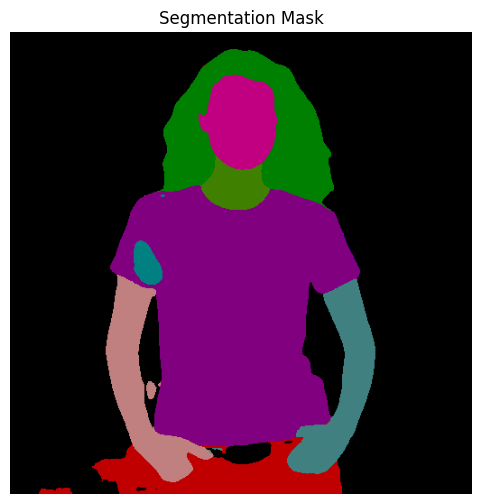

Segmentation mask saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask.png


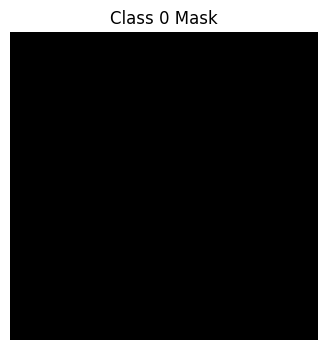

Segmentation mask for class 0 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_0.png


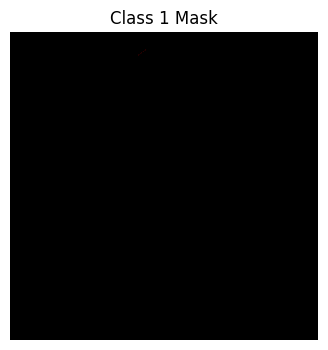

Segmentation mask for class 1 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_1.png


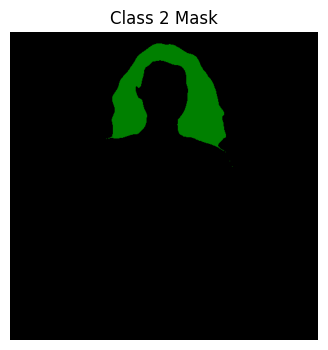

Segmentation mask for class 2 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_2.png


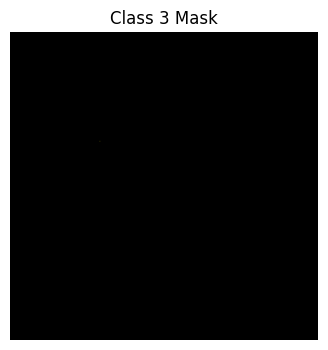

Segmentation mask for class 3 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_3.png


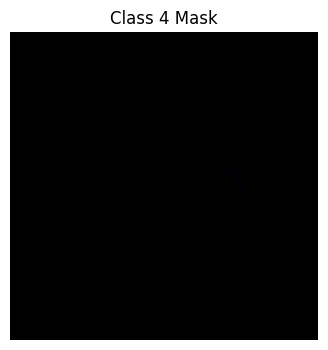

Segmentation mask for class 4 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_4.png


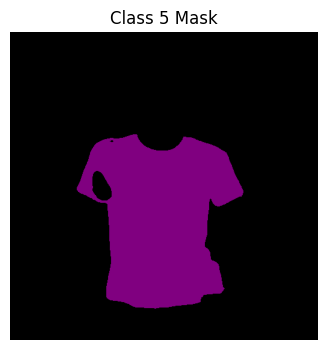

Segmentation mask for class 5 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_5.png


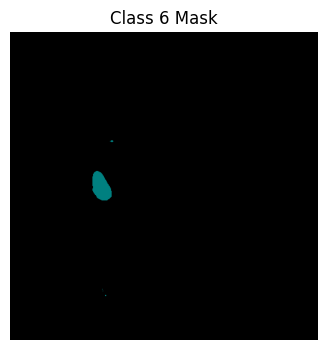

Segmentation mask for class 6 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_6.png


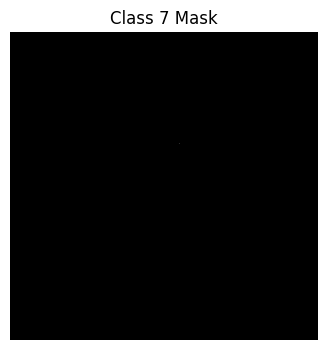

Segmentation mask for class 7 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_7.png


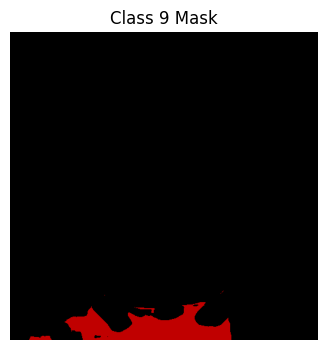

Segmentation mask for class 9 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_9.png


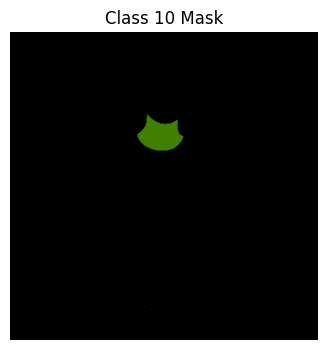

Segmentation mask for class 10 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_10.png


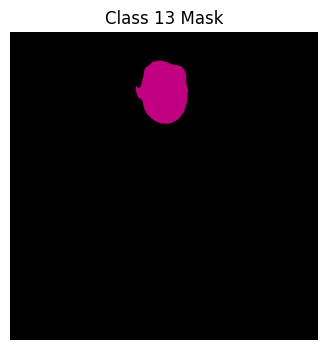

Segmentation mask for class 13 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_13.png


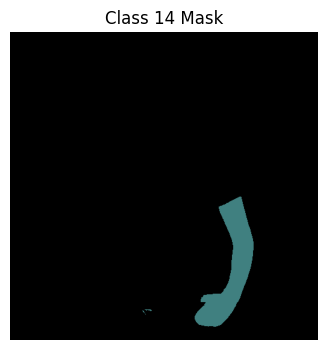

Segmentation mask for class 14 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_14.png


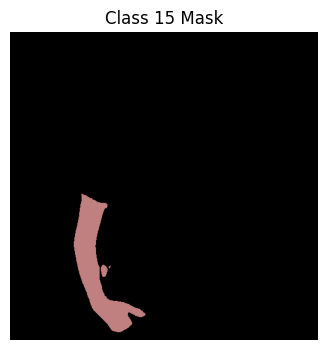

Segmentation mask for class 15 saved as /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/bodysegmask/segmentation_mask_class_15.png


In [23]:
# Load model
model = onnxruntime.InferenceSession(os.path.join(BODY_PARSING_MODEL, "deeplabv3p-resnet50-human.onnx"))

person_image = INPUT_DIR + "/person_image1.jpg"  # Replace with your image path

# Load and preprocess image
img = Image.open(person_image)
img = img.resize((512, 512))
img = np.array(img).astype(np.float32) / 255.0  # Normalize

# Get expected input shape
input_shape = model.get_inputs()[0].shape

# Reshape input
if len(input_shape) == 4 and input_shape[1] == 3:
    img = img.transpose(2, 0, 1)  # (H, W, C) → (C, H, W)
    img = img[np.newaxis, ...]     # (C, H, W) → (1, C, H, W)
elif len(input_shape) == 4 and input_shape[3] == 3:
    img = img[np.newaxis, ...]     # (H, W, C) → (1, H, W, C)

# Model inference
input_name = model.get_inputs()[0].name
output_name = model.get_outputs()[0].name
result = model.run([output_name], {input_name: img})

# Metrics Code - Awaiting Image Database with ground truth
# num_classes = 21  # Number of classes, including background

# # Load ground truth mask (replace with your ground truth loading logic)
# gt_mask_path = os.path.join(INPUT_DIR, "ground_truth_masks", "person_image1.png")
# gt_mask = Image.open(gt_mask_path)
# gt_mask = gt_mask.resize((512, 512))
# gt_mask = np.array(gt_mask)

# # Calculate mIoU and FWIoU (assuming you have a list of predictions and ground truths)
# miou, fwiou = calculate_miou_fwiou([result], [gt_mask], num_classes)

# print(f"mIoU: {miou}")
# print(f"FWIoU: {fwiou}")

# Convert result to numpy
result = np.array(result[0])
print("result before squeeze:", result.shape)  # Should be (1, 21, 512, 512) or similar

# Get class predictions (argmax over classes dimension)
result = result.argmax(axis=-1).squeeze(0)  # Now (512, 512)
print("result after squeeze:", result.shape)
define_custom_color_map()
# Map each pixel to its corresponding color
mask_color = colors[result]  # Resulting shape: (512, 512, 3)

# Option 1: Display inline using Matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(mask_color)
plt.title("Segmentation Mask")
plt.axis('off')
plt.show()

# Option 2: Save the mask to disk
output_img = Image.fromarray(mask_color)
output_image_path = OUTPUT_DIR + "/bodysegmask/segmentation_mask.png"
output_img.save(output_image_path)
print(f"Segmentation mask saved as {output_image_path}")

print_individual_class_masks()
